# Prompt Generation for ROFT (Real or Fake Text?) -- http://roft.io/

Developed by Liam Dugan, Arun Kirubarajan, and Daphne Ippolito in Spring 2020 ([Github](https://github.com/kirubarajan/roft.git))

## Step 1: Setup

In [1]:
# Mount your google drive folder
!gsutil cp gs://roft_datasets/prompts/story_prompts/reddit-stories-test.txt .
DATASET_NAME = 'reddit-stories-test'

Copying gs://roft_datasets/prompts/story_prompts/reddit-stories-test.txt...
\ [1 files][ 21.2 MiB/ 21.2 MiB]                                                
Operation completed over 1 objects/21.2 MiB.                                     


In [2]:
import os
import random
import mmap
import numpy as np
import json
import time

In [3]:
!pip3 install profanity_filter
!python3 -m spacy download en

     |████████████████████████████████| 51kB 3.8MB/s 
     |████████████████████████████████| 665kB 11.4MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 7.4MB 22.0MB/s 
  Created wheel for ordered-set: filename=ordered_set-3.1.1-py2.py3-none-any.whl size=7813 sha256=accf391f8c04df3a84a6ad6cddba5f12e47c7fefb73dcd3c03540ff20167c12f
  Stored in directory: /root/.cache/pip/wheels/dd/70/f1/0a4953bd6d06e7dbffe8ef0197b558eaecb21fa6b043b50d73
Successfully built ordered-set
  Found existing installation: dataclasses 0.7
    Uninstalling dataclasses-0.7:
      Successfully uninstalled dataclasses-0.7
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [4]:
import nltk 
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

!pip install -q git+https://github.com/huggingface/transformers.git

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 3.0MB 8.3MB/s 
     |████████████████████████████████| 1.1MB 64.6MB/s 
     |████████████████████████████████| 890kB 69.1MB/s 


## Step 2: Sample Prompts from Human Text




In [12]:
def print_prompt_sampled(prompt, index, total, line):
  print('Sampled prompt {0}/{1} of length {2} from line {3}'.format(
          str(index), str(total), str(len(prompt)), str(line)))
  for line in prompt:
    print('\t' + repr(line))

def print_prompt_too_short_warning(index, article_len, prompt_len):
  print('Warning: Article #{0} (len: {1}) is too short for prompt length of {2}'.format(
            str(index), str(article_len), str(prompt_len)))
  
def random_sample_prompt_len(percent_human, max_prompt_len):
  if (random.random() < percent_human):
    return max_prompt_len
  else:
    return random.randint(1, max_prompt_len)
    
def sample_corpus(sample_file, num_samples, max_prompt_len, percent_human, random_seed=436421):
  random.seed(random_seed)

  if not os.path.exists(sample_file):
    print('Error: sample file "' + sample_file + '" does not exist')
    exit(-1)

  prompts = [] # The 2D array of prompts
  num_shortened = 0 # The number of prompts that were too small to be full length
  with open(sample_file, 'r+b') as f:
    # mmap the file to avoid loading the whole thing into RAM
    map_file = mmap.mmap(f.fileno(), 0, prot=mmap.PROT_READ)
    
    # Randomly decide which articles to grab our prompts from
    wc_output = !wc -l $sample_file
    num_lines = int(wc_output[0].split()[0])
    articles_to_sample = random.sample(range(num_lines), num_samples)

    # Iterate over all articles in the file and sample from only the selected articles
    for index, line in enumerate(iter(map_file.readline, b"")):
      if index not in articles_to_sample: continue

      # Randomly determine this prompt's length based on the percent human value
      prompt_length = random_sample_prompt_len(percent_human, max_prompt_len)

      # Use NLTK Sentence tokenizer to split this prompt into sentences
      article = sent_detector.tokenize(str(line, 'utf-8', 'ignore'))

      # If article is shorter than the desired prompt length, shorten the prompt length
      if len(article) < prompt_length: 
        print_prompt_too_short_warning(index, len(article), prompt_length)
        prompt_length = len(article)
        num_shortened += 1

      # Append the prompt to the list of prompts
      prompts.append(article[:prompt_length])

      print_prompt_sampled(article[:prompt_length], len(prompts), num_samples, index)
  
  print('Warning: {0} articles were too short for prompt length'.format(str(num_shortened)))
  return prompts

NUM_EXAMPLES_PER_HPARAM = 150
HPARAM_VALUES = np.arange(0.000000, 1.10000000, 0.10000000).tolist()
NUM_GENS = NUM_EXAMPLES_PER_HPARAM * len(HPARAM_VALUES)
MAX_LEN = 11
PERCENT_HUMAN = 0.10

# prompts_valid = sample_corpus('/content/reddit-stories-test.txt', NUM_GENS, MAX_LEN, PERCENT_HUMAN)
prompts_test = sample_corpus('/content/reddit-stories-valid.txt', NUM_GENS, MAX_LEN, PERCENT_HUMAN)

Streaming output truncated to the last 5000 lines.
	'Stay away from Sarah and her bullshit.'
	'Spend time with Mom, she goes off the deep end.'
	'Dad leaves in a few years.'
	'So get your act together and move out at eighteen.'
	"Don't hang out with Freddy anymore."
	"He's a dick."
	'He sleeps with Sarah after you get married.'
	"While we are on it don't sleep with Sarah."
	'Jimmy from across the street is gay and will drug you.'
Sampled prompt 448/1100 of length 2 from line 3126
	'"So what do you guys have?"'
	'Anna asked.'
Sampled prompt 449/1100 of length 4 from line 3128
	'Han was ready.'
	'The weight of the blaster hidden beneath the table was a welcome reminder that those who shoot first are the ones who live.'
	'His nonchalant slouch belied the tension in his body.'
	'"This isn\'t even fair," he thought to himself as Greedo\'s hand began to clench.'
Sampled prompt 450/1100 of length 9 from line 3134
	'Since the first day I told my best friend about my plan he has called me an id

Let's look at the length distribution of prompts.

(array([ 95.,  79., 101.,  83., 101.,  82.,  95.,  91.,  92., 100., 181.]),
 array([ 1.        ,  1.90909091,  2.81818182,  3.72727273,  4.63636364,
         5.54545455,  6.45454545,  7.36363636,  8.27272727,  9.18181818,
        10.09090909, 11.        ]),
 <a list of 11 Patch objects>)

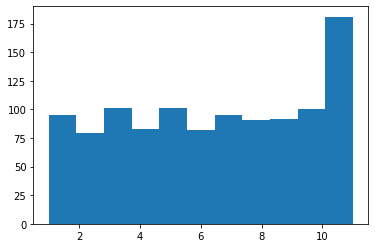

In [14]:
import matplotlib.pyplot as plt
plt.hist([len(x) for x in prompts], bins=11)

## Step 3: Filter Prompts for Duplicates and Profanity

In [6]:
from profanity_filter import ProfanityFilter
pf = ProfanityFilter()

In [ ]:
def filter_profanity(prompts):
  return [prompt for prompt in prompts if not pf.is_profane(''.join(prompt))]

def filter_duplicates(prompts): 
  ''' For our purposes, a duplicate is considered to be two prompts with same starting sent
     Because we only ever sample from beginning of articles, this means that this function 
     will filter out all prompts from the same article even if they have different lengths '''
  prompt_set = set([prompt[0] for prompt in prompts]) # Use a set to avoid O(n^2)
  for prompt in prompts:
    prompt_set.discard(prompt[0])
    if prompt[0] in prompt_set:
      prompts.remove(prompt)
  return prompts

pre_filter_len = len(prompts)
prompts = filter_profanity(prompts)
print("Profanity filtering reduced len by " + str(pre_filter_len - len(prompts)))

pre_filter_len = len(prompts)
prompts = filter_duplicates(prompts)
print("Duplicate filtering reduced len by " + str(pre_filter_len - len(prompts)))

## Step 4: Generate with pre-trained GPT-2





In [8]:
prompts_per_p = {}
for idx, p in enumerate(HPARAM_VALUES):
  prompts_per_p[p] = prompts[idx*NUM_EXAMPLES_PER_HPARAM:(idx+1)*NUM_EXAMPLES_PER_HPARAM]

In [9]:
import tensorflow as tf
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = TFGPT2LMHeadModel.from_pretrained("gpt2-xl", pad_token_id=tokenizer.eos_token_id)

All model checkpoint weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-xl.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [10]:
def generate(prompts_per_p, p):
  # set seed to reproduce results. Feel free to change the seed though to get different results
  tf.random.set_seed(int(p*100))

  examples = []

  for prompt_index, prompt in enumerate(prompts_per_p[p]):
    print('{}/{}'.format(prompt_index+1, len(prompts_per_p[p])))
    if len(prompt) == 10:
      examples.append({
          'prompt': prompt,
          'continuation': []
      })
    else:
      prompt_text = ' '.join(prompt)
      input_ids = tokenizer.encode(prompt_text, return_tensors='tf')

      continuation_length = 0
      retry_counter = 0

      while continuation_length + len(prompt) < 10 and retry_counter < 5:
        retry_counter += 1

        # deactivate top_k sampling and sample only from 92% most likely words
        start_time = time.time()
        sample_output = model.generate(
            input_ids, 
            do_sample=True, 
            max_length=256, 
            top_p=p, 
            top_k=0
        )
        total_time = time.time() - start_time

        output_tokens = sample_output[0]
        continuation = tokenizer.decode(output_tokens, skip_special_tokens=True)
        continuation = sent_detector.tokenize(continuation)[len(prompt):]
        continuation_length = len(continuation)
        print('{} sentences in prompt, {} sentences generated in {} seconds'.format(
            len(prompt), continuation_length, total_time))
        print('Total length is {}'.format(continuation_length + len(prompt)))

        continuation = continuation[:(10 - len(prompt))]

      examples.append({
          'prompt': prompt,
          'continuation': continuation
      })
    to_save = {
        'dataset': 'reddit-stories',
        'split': 'test',
        'p': p,
        'examples': examples
    }
  with open('examples-{}-p{}.json'.format(DATASET_NAME, p), 'w') as f:
    json.dump(to_save, f, indent=2)
  
  return to_save

generate(prompts_per_p, 0.0)
!gsutil cp /content/examples-reddit-stories-test-p0.0.json  gs://roft_datasets/generations/

1/100
9 sentences in prompt, 16 sentences generated in 70.61562418937683 seconds
Total length is 25
2/100
5 sentences in prompt, 22 sentences generated in 79.41327095031738 seconds
Total length is 27
3/100
1 sentences in prompt, 14 sentences generated in 107.3490800857544 seconds
Total length is 15
4/100
2 sentences in prompt, 27 sentences generated in 80.57533097267151 seconds
Total length is 29
5/100
1 sentences in prompt, 19 sentences generated in 97.65213131904602 seconds
Total length is 20
6/100
4 sentences in prompt, 57 sentences generated in 101.98283910751343 seconds
Total length is 61
7/100
8 sentences in prompt, 2 sentences generated in 12.885463237762451 seconds
Total length is 10
8/100


KeyboardInterrupt: ignored